In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'
from einops import rearrange

mps


In [39]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


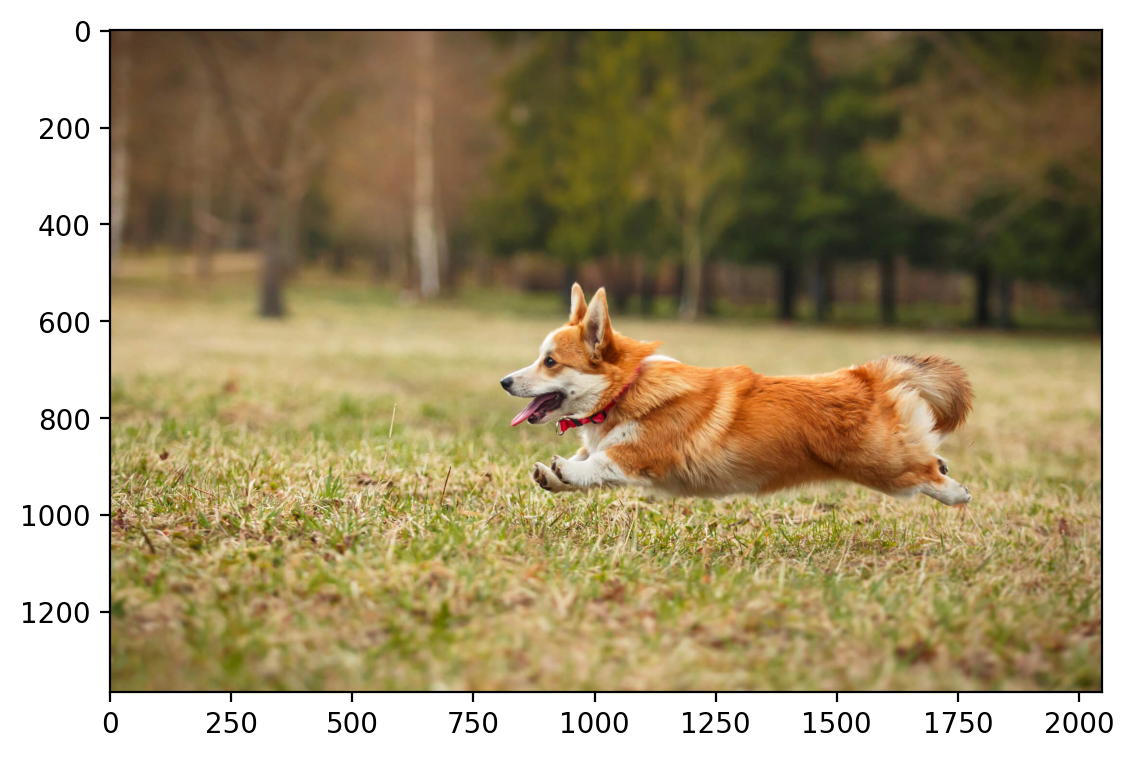

In [40]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [41]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [42]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [43]:
img_scaled = img_scaled.to('cpu')
img_scaled.shape

torch.Size([3, 1365, 2048])

In [44]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

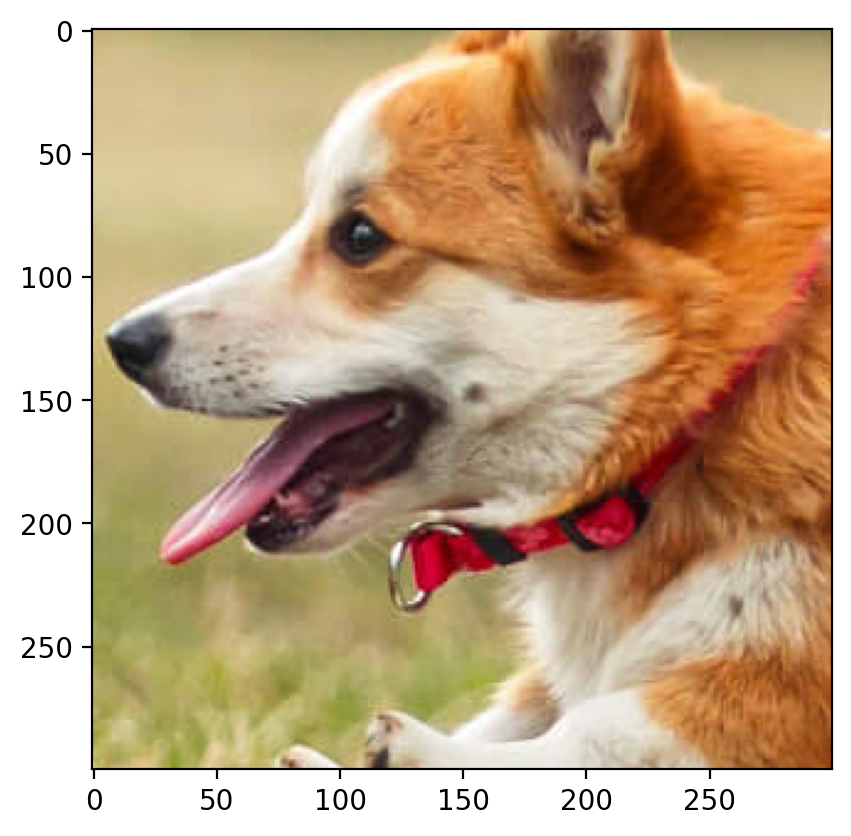

In [45]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [46]:
# Modify the loss function to ignore NaN values
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [55]:
from sklearn.metrics import mean_squared_error

def plot(original_image, k_values=[5, 10, 25, 50], device='cpu'):
    fig, axs = plt.subplots(1, 1 + len(k_values), figsize=(20, 5.5))
    axs[0].imshow(rearrange(original_image, 'c h w -> h w c').detach().numpy())
    #original_image = original_image.to(device)
    #original_img_np = original_image.cpu().detach().numpy()
    #axs[0].imshow(original_img_np, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    matrixr = original_image[0, :, :]  
    matrixg = original_image[1, :, :]  
    matrixb = original_image[2, :, :]  
    
    for i, k in enumerate(k_values):
        Wr, Hr, lossr = factorize(matrixr, k, device=device)
        Wg, Hg, lossg = factorize(matrixg, k, device=device)
        Wb, Hb, lossb = factorize(matrixb, k, device=device)

        reconstructed_img = torch.stack([torch.mm(Wr,Hr), torch.mm(Wg,Hg), torch.mm(Wb,Hb)], dim=0)

        original_flat = original_image.reshape(-1)
        reconstructed_flat = reconstructed_img.reshape(-1)
    
        # Compute the RMSE
        mse = torch.mean((original_flat - reconstructed_flat) ** 2)  # Mean Squared Error
        rmse = torch.sqrt(mse)  # Root Mean Squared Error
        #rmse = np.sqrt(mean_squared_error(original_image.cpu().detach().numpy(), reconstructed_img.cpu().detach().numpy()))
        psnr = 20 * np.log10(1.0 / rmse.detach().numpy())
        if rmse == 0:
            psnr = float('inf')              
        #reconstructed_img_np = reconstructed_img.cpu().detach().numpy()
        axs[i + 1].imshow(rearrange(reconstructed_img, 'c h w -> h w c').detach().numpy())
        #axs[i + 1].set_title(f'k={k}, Loss={loss.item():.4f}, RMSE={rmse:.4f}, \n PSNR={psnr:.4f}')
        axs[i + 1].set_title(f'r={k}, RMSE={rmse:.4f}, \n PSNR={psnr:.4f} dB')
        axs[i + 1].axis('off')

    plt.suptitle('Original and Reconstructed Images for Different rank(r) Values')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


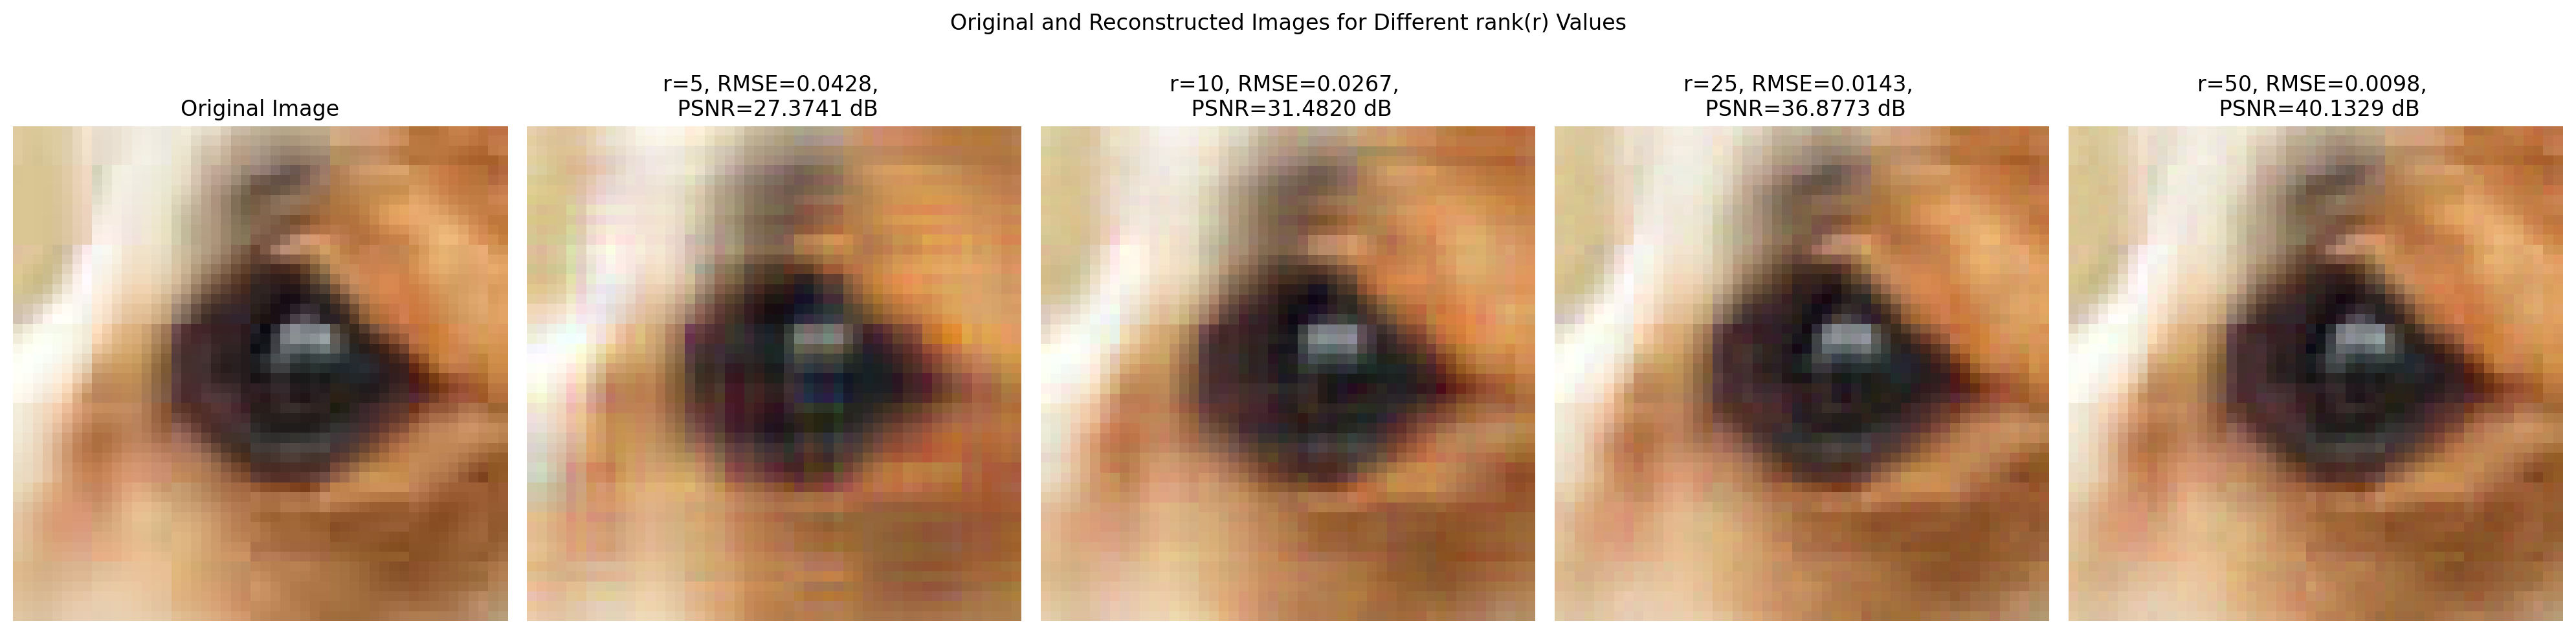

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


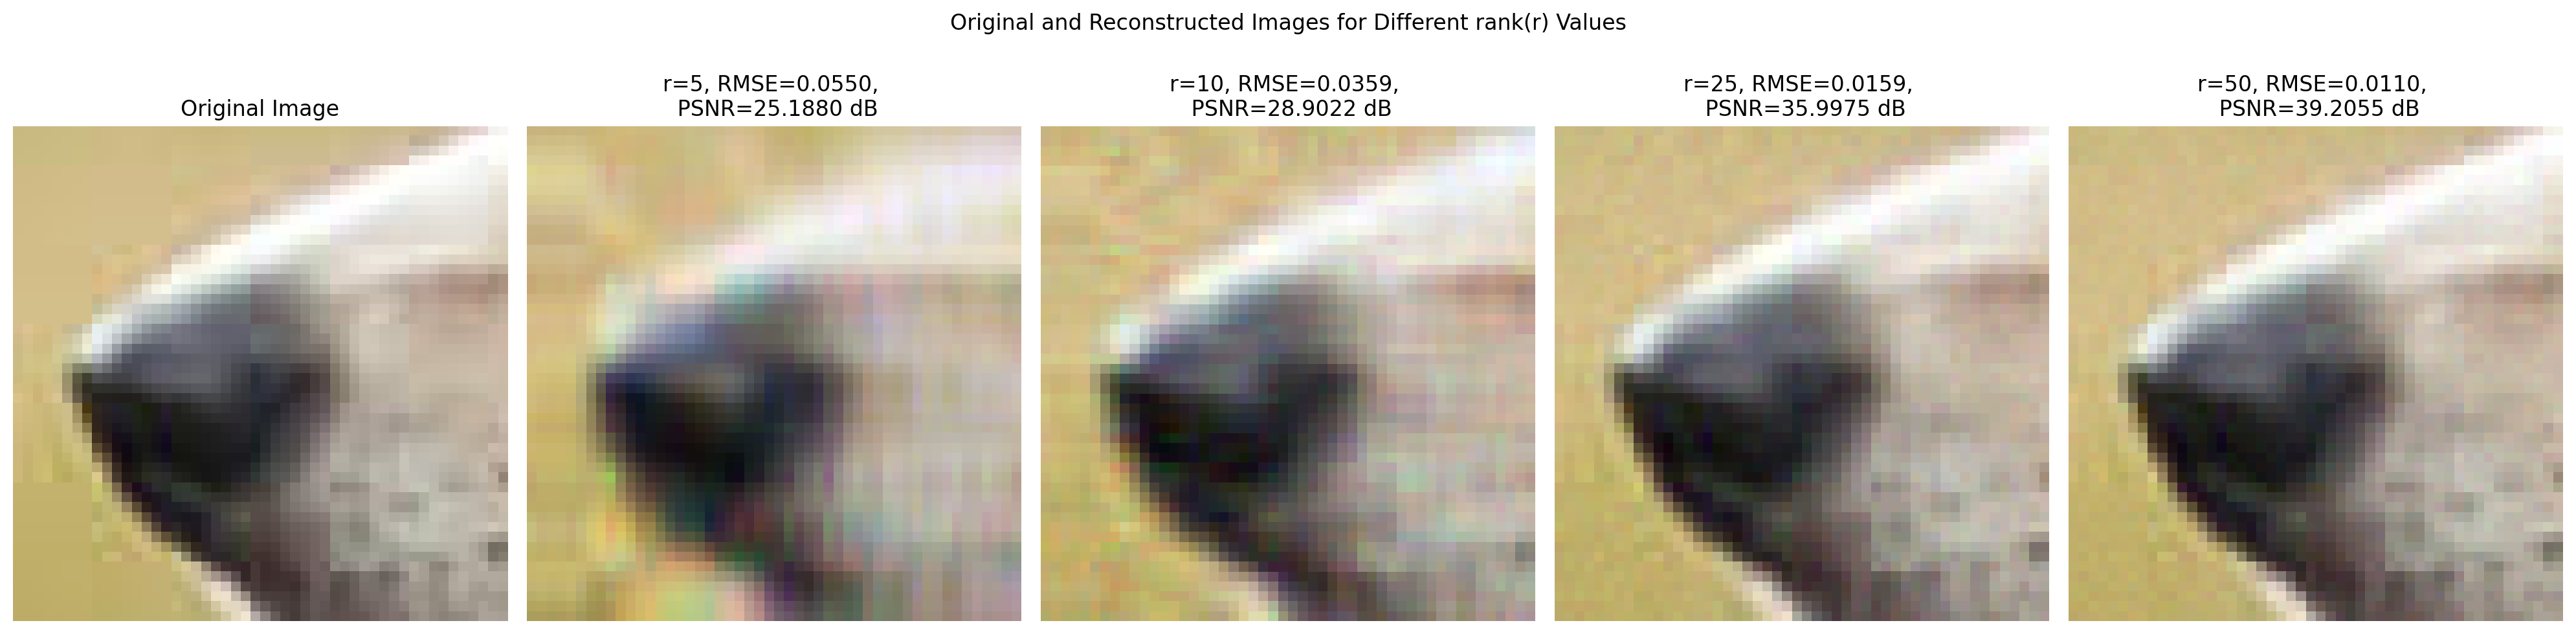

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


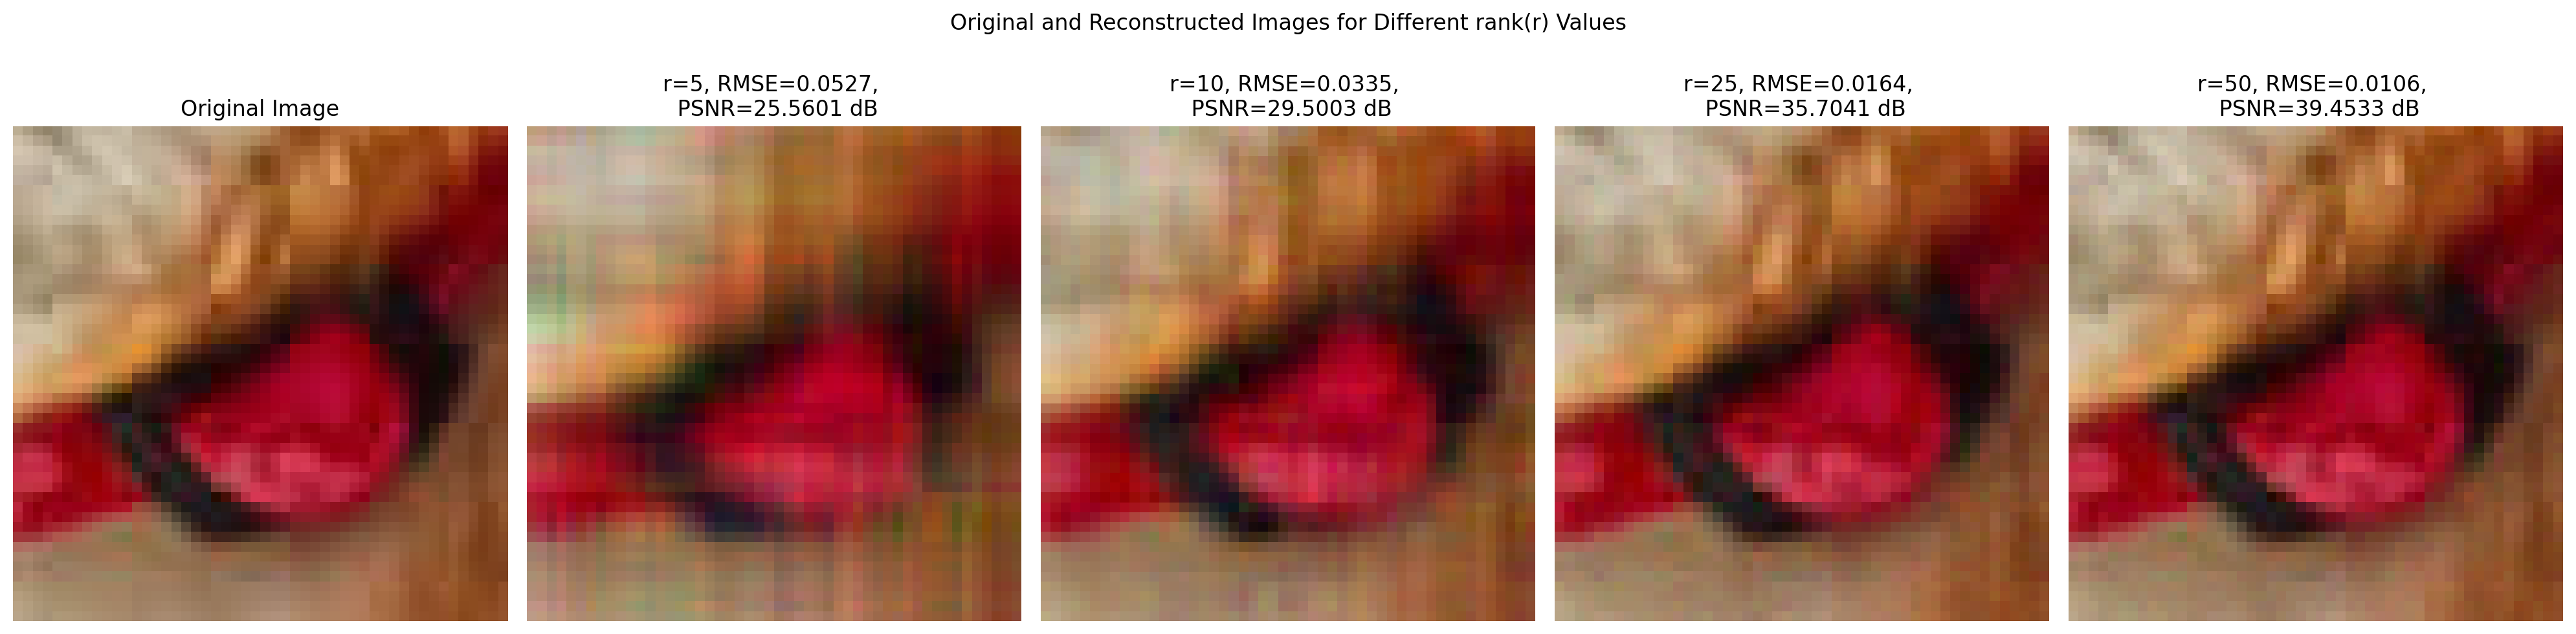

In [56]:
patch1, patch2 = torchvision.transforms.functional.crop(crop, 60, 80, 50, 50), torchvision.transforms.functional.crop(crop, 100, 0, 50, 50)
patch3 = torchvision.transforms.functional.crop(crop, 170, 180, 50, 50)

plot(patch1)
plot(patch2)
plot(patch3)